## Imports

In [52]:
import jax
import networkx
import pandas as pd
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
from dgl import data
from functools import partial
from tqdm import notebook as tqdm
from sklearn.preprocessing import OneHotEncoder
from jax import random as r
from jax.experimental import optimizers
from jax.experimental.stax import Dropout
from jax.flatten_util import ravel_pytree

## Dataset

In this section we just download and preprocess CoRa.

In [53]:
cora = data.citation_graph.CoraDataset()
X = cora.features
y = cora.labels

In [54]:
G = cora.graph
A = networkx.to_numpy_matrix(G).A

In [56]:
train_idx = cora.train_mask.astype(onp.bool)
val_idx = cora.val_mask.astype(onp.bool)
test_idx = cora.test_mask.astype(onp.bool)

In [57]:
y_onehot = OneHotEncoder(sparse=False).fit_transform(y.reshape(-1, 1))

In [58]:
input_size = X.shape[1]
output_size = onp.max(y) + 1

## Agents Network

This part of the code defines the topology of the network of agents.
Each agent will have its own set of trainable parameters.

In [394]:
N_agents = 10 # number of agents in the network
P = 0.5 # Probabilty of keeping an edge between two agents
lr = 0.007 # learning rate for adam optimizer
iters = 200 # number of epochs/iterations
hidden_size = 64 # dimension of the hiddel layers of the GCN
key = r.PRNGKey(42)

In [395]:
def check_connected(M_agents):
    '''
    input: adjacency matrix of the agents' network
    This function checks that there are no isolated agents.
    '''
    tot = M_agents
    tmp = M_agents
    for i in range(M_agents.shape[0]):
        tmp = np.matmul(tmp, M_agents)
        tot += tmp
    return (tot>0.).all()

In [396]:
def communication_mask(N_agents, P, key):
    '''
    input: (Number of agents, Probability, jax seed)
    This function creates a random adjacecy matrix of size 
    N_agents X N_agents representing the agents' network.
    Thhere are no disconnected components by construction.

    '''
    M_agents = np.zeros((N_agents,N_agents))
    indices = np.triu_indices(N_agents,k=1)
    agents_mask = r.bernoulli(p=P,
                              shape=(int(N_agents*(N_agents-1)/2),),
                              key=key)
    M_agents = jax.ops.index_update(M_agents,indices,agents_mask)
    M_agents += M_agents.T + np.eye(N_agents)
    if check_connected(M_agents):
        return M_agents
    else:
        print("Disconnected graph, retrying...")
        _, subkey = r.split(key)
        return  communication_mask(N_agents,P, subkey)

In [397]:
M_agents = communication_mask(N_agents,P,key)

In [398]:
M_agents

DeviceArray([[1., 0., 1., 0., 1., 0., 1., 0., 1., 1.],
             [0., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
             [1., 0., 1., 1., 0., 0., 1., 0., 1., 1.],
             [0., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
             [1., 1., 0., 0., 1., 1., 0., 1., 1., 0.],
             [0., 0., 0., 1., 1., 1., 1., 0., 0., 1.],
             [1., 0., 1., 0., 0., 1., 1., 1., 0., 1.],
             [0., 0., 0., 0., 1., 0., 1., 1., 1., 1.],
             [1., 1., 1., 1., 1., 0., 0., 1., 1., 1.],
             [1., 0., 1., 0., 0., 1., 1., 1., 1., 1.]], dtype=float32)

## Node Assignment
Here we assign a subset of the nodes in the graph to each agent.
Here these procedure is perfomed randomly. However, preferential attachment or
spectral clustering can be used to include "locality" in the assignment. 

The adjacency matrix of the graph is modified such that we remove the edges between nodes located on agents that are not directly connected.

In [399]:
node_to_agent = r.randint(minval=0, maxval=N_agents, shape=(X.shape[0], ), key=key)

In [400]:
def prune_connections(A, M_agents, node_to_agent):
    '''
    input: (graph adjacecy, agents adjacecy, node assignment)
    Remove connections between agents that cannot communicate
    '''
    new_A = A
    if not M_agents.all():
        for i in range(N_agents):
            I = (node_to_agent==i).astype('int32')
            for j in range(i+1,N_agents):
                J = (node_to_agent==j).astype('int32')
                if M_agents[i,j]==0:
                    IJ = np.outer(I,J)
                    new_A -= (A*IJ)
    return new_A

In [401]:
# preprocess adjacecy matrix for graph convolutions
new_A = prune_connections(A, M_agents, node_to_agent)
new_Aself = new_A + onp.eye(new_A.shape[0])
new_d = new_Aself.sum(axis=1)
new_W = np.dot(onp.diag(1.0 / new_d), new_A + new_Aself)

## Consensus Matrix


In [402]:
def compute_consensus_matrix(new_A, N_agents, node_to_agent):
    '''
    input: (graph adjacecy, number of agents, node assignment)
    output: combination whose sparsity pattern reflects the topology of
    the communication graph. The matrix posses a set of properties  needed
    to guarantee the convergence of the optimization process (A1-A3 in the paper)
    '''
    W_agents = np.zeros((N_agents,N_agents))
    if N_agents > 1:
        for i in range(N_agents):
            I = (node_to_agent==i).astype('int16')
            for j in range(i,N_agents):
                J = (node_to_agent==j).astype('int16')
                IJ = np.outer(I, J)
                edges = (new_A * IJ).sum()
                W_agents = jax.ops.index_update(W_agents,(i,j),edges)
                W_agents = jax.ops.index_update(W_agents,(j,i),edges)

        W_agents = W_agents / W_agents.sum(axis=0) 
    else:
        W_agents = np.ones((1,1))

    return W_agents

In [403]:
agents_W = compute_consensus_matrix(new_A, N_agents, node_to_agent)

In [404]:
agents_W

DeviceArray([[0.16107382, 0.        , 0.16123779, 0.        , 0.16552901,
              0.        , 0.15873016, 0.        , 0.10394737, 0.12226512],
             [0.        , 0.3809524 , 0.        , 0.        , 0.15017065,
              0.        , 0.        , 0.        , 0.12368421, 0.        ],
             [0.16610739, 0.        , 0.13680781, 0.25194806, 0.        ,
              0.        , 0.16727717, 0.        , 0.11973684, 0.13642214],
             [0.        , 0.        , 0.15798046, 0.29090908, 0.        ,
              0.19153675, 0.        , 0.        , 0.11842106, 0.        ],
             [0.16275167, 0.2993197 , 0.        , 0.        , 0.19795223,
              0.20489977, 0.        , 0.15181518, 0.13289474, 0.        ],
             [0.        , 0.        , 0.        , 0.22337662, 0.1569966 ,
              0.19599108, 0.11355311, 0.        , 0.        , 0.11583012],
             [0.2181208 , 0.        , 0.22312704, 0.        , 0.        ,
              0.20712695, 0.2051

## Training

In [405]:
def cross_entropy(y, ypred):
    return - np.mean(np.sum(y * np.log(ypred), axis=1))

In [406]:
def accuracy(y, ypred):
    return np.mean(np.argmax(y, axis=1) == np.argmax(ypred, axis=1))

In [407]:
def init_params(key):
    '''
    jax initialization of the parameters required by a 2 layer GCN
    '''
    _, subkey1 = r.split(key)
    theta_l1 = jax.nn.initializers.lecun_normal()(key=key,
                                                  shape=(input_size, hidden_size))
    theta_l2 = jax.nn.initializers.lecun_normal()(key=subkey1,
                                                  shape=(hidden_size, output_size))
    b_l1 = np.zeros((hidden_size))
    b_l2 = np.zeros((output_size))
    return [theta_l1, b_l1, theta_l2, b_l2]

In [408]:
def init_params_dist(key):
    '''
    initialize the parameters for each agent
    '''
    _, *subkeys = r.split(key, num=N_agents+1)
    params = []
    for i in range(N_agents):
        params.append(init_params(subkeys[i]))
    return params

In [409]:
@partial(jax.jit, static_argnums=(3))
def dist_gcn(params, L, X, mode, key=r.PRNGKey(0)):
    '''
    input: (agents' parameters, diffusion operator, train/test, jax seed)
    This function builds a distributed GCN. This GCN updates independently the
    weights of each agent.
    '''
    _, dropout_fcn = Dropout(0.5, mode=mode)
    _, subkey = r.split(key)
    X = dropout_fcn(_, X, rng=key)

    H = np.zeros((X.shape[0], hidden_size))
    for i in range(N_agents):
        H = jax.ops.index_update(H, node_to_agent == i,
                                 np.dot(X[node_to_agent == i],
                                 params[i][0]) + params[i][1])

    H = np.dot(L, H)
    H = jax.nn.relu(H)
    H = dropout_fcn(_, H, rng=subkey)
 
    Y = np.zeros((X.shape[0], output_size))
    for i in range(N_agents):
        Y = jax.ops.index_update(Y, node_to_agent == i,
                                 np.dot(H[node_to_agent == i],
                                 params[i][2]) + params[i][3])
  
    return jax.nn.softmax(np.dot(L, Y), axis=1)

In [410]:
def loss(params, L, key):
    '''
    input:(agents' parameters, diffusion operator, jax random seed)
    The function performs a forward step and compute the cross-entropy loss for
    each agent.
    '''
    ypred = dist_gcn(params, L, X, 'train', key=key)
    losses = cross_entropy(y_onehot[train_idx, :], ypred[train_idx, :])
    return np.mean(losses), (ypred, losses)
loss_and_grad = jax.jit(jax.value_and_grad(loss, has_aux=True)) # jax black magic

In [411]:
@jax.jit
def consensus_step(params, W):
    '''
    input:(agents' parameters, agents'consensus matrix)
    output: new set of weights for each agent. An agent averages its weight with
    the ones of the agents in its neighborhood.
    '''
    flatten = [ravel_pytree(p) for p in params]
    p_flat = np.vstack(f[0] for f in flatten)
    p_flat = np.dot(W, p_flat)
    return [flatten[i][1](p_flat[i]) for i in range(p_flat.shape[0])]

## Initialization

In [412]:
params = init_params_dist(key)
agents_opts = []
agents_opts_states = []
for i in range(N_agents):
    agents_opts.append(optimizers.adam(lr))
    agents_opts_states.append(agents_opts[i][0](params[i]))

## Training

In [413]:
bar = tqdm.tqdm(range(iters))
_, subkey = r.split(key)
best_acc = best_val_acc = best_epoch = 0
results =  {'tr_loss':[],'tr_acc':[],'te_acc':[],'best_acc':[],'best_epoch':[]}
for i in bar:
    subkey, subkey2 = r.split(subkey)
    # feedforward step
    (loss_i, ypred), grads = loss_and_grad(params, new_W, subkey2)

    if i>0: #consensus performed after each iteration
        agents_opts_states = consensus_step(agents_opts_states, agents_W)

    for k in range(N_agents): # parameters' update
        agents_opts_states[k] = agents_opts[k][1](i, grads[k], agents_opts_states[k])
        params[k] = agents_opts[k][2](agents_opts_states[k])

    ypred = dist_gcn(params, new_W, X, 'test')

    train_acc_i = accuracy(y_onehot[train_idx, :], ypred[train_idx, :])
    val_acc_i = accuracy(y_onehot[val_idx, :], ypred[val_idx, :])
    test_acc_i = accuracy(y_onehot[test_idx, :], ypred[test_idx, :])

    if val_acc_i > best_val_acc:
        best_val_acc = val_acc_i
        best_acc = test_acc_i
        best_epoch = i

    results['tr_loss'].append(loss_i)
    results['tr_acc'].append(train_acc_i)
    results['te_acc'].append(test_acc_i)

results['best_acc'] = best_acc
results['best_epoch'] = best_epoch

  0%|          | 0/200 [00:00<?, ?it/s]

## Results

In [414]:
print(f"Best epoch:{results['best_epoch']}, Best Accuracy:{results['best_acc']}")

Best epoch:124, Best Accuracy:0.8090000152587891


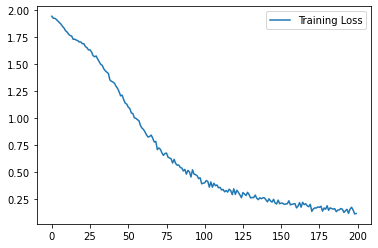

In [415]:
plt.plot(results['tr_loss'], label="Training Loss")
plt.legend()

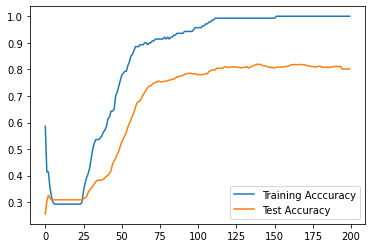

In [416]:
plt.plot(results['tr_acc'], label="Training Acccuracy")
plt.plot(results['te_acc'], label="Test Accuracy")
plt.legend()